# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [8]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [9]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

def plot_image_mask_box_points(image, masks=None, boxes=None, points=None, input_label=None, ax=None):
    """    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    if masks is not None:
        for mask in masks:
            show_mask(mask, plt.gca())
    if (points is not None) and (input_label is not None):
        show_points(points, input_label, plt.gca())
    if boxes is not None:
        for box in boxes:
            show_box(box=box, ax=plt.gca())
    plt.axis('off')
    plt.show()

    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

In [13]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

0 255 (112, 256, 256, 3) (112, 256, 256)
0 255
0 255


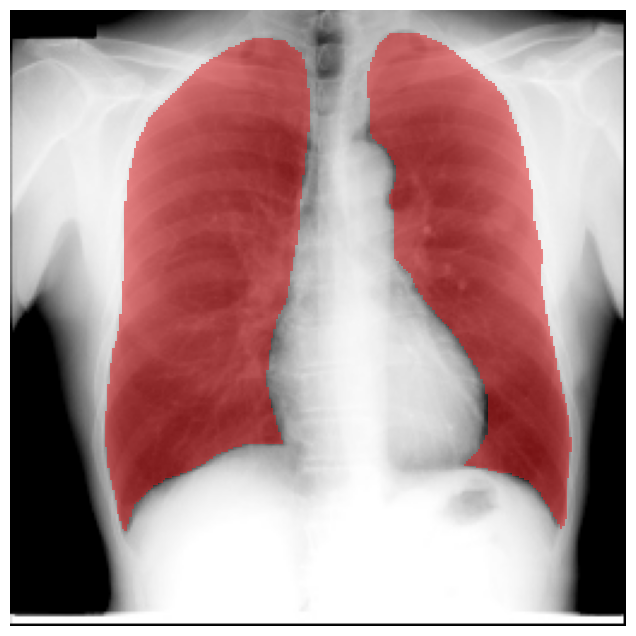

In [14]:
# TODO: 
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE
'''
On the other hand, ndarray.flatten always returns a flattened copy of the array. However, to guarantee a view in most cases, x.reshape(-1) may be preferable.
'''
def process_data(x, y, min=None, max=None):
    if min==None and max==None:
        min = x.min()
        max = x.max()
    
    x = (x - min)/(max - min) * 255
    x = x.astype(np.uint8)
    y = y.astype(np.uint8)
    x = np.concatenate([x,x,x], axis=3)
    y = y[:,:,:,0]
    return x, y, min, max

x_train, y_train, min, max = process_data(x_train, y_train)
print(np.min(x_train.reshape(-1)), np.max(x_train.reshape(-1)), x_train.shape, y_train.shape)

x_val, y_val,_,_= process_data(x_val, y_val, min, max) 
print(np.min(x_val.reshape(-1)), np.max(x_val.reshape(-1)))

x_test, y_test,_,_= process_data(x_test, y_test, min, max)
print(np.min(x_test.reshape(-1)), np.max(x_test.reshape(-1)))

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [15]:
example_img, example_mask = x_train[0], y_train[0]

# input_points = np.array([[90, 50], [180, 50], [80, 150], [210, 150]]) # TODO: Pick apropriate input points, 
# input_label = np.array([1, 1, 1, 1]) # TODO: Pick apropriate input labels

input_points = np.array([[90, 100], [180, 100]]) # TODO: Pick apropriate input points, 
input_label = np.array([1, 1]) # TODO: Pick apropriate input labels

example_img.shape

(256, 256, 3)

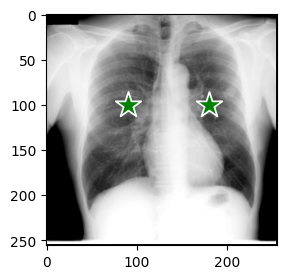

In [16]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [17]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

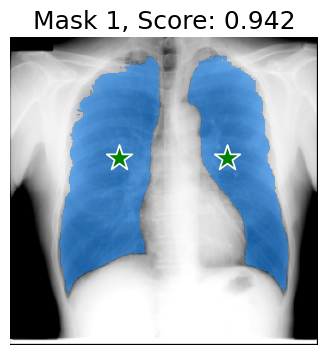

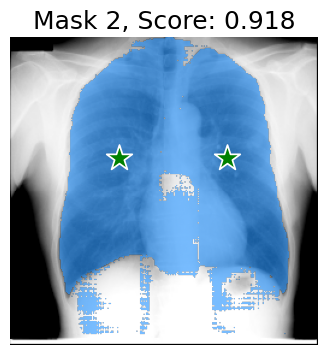

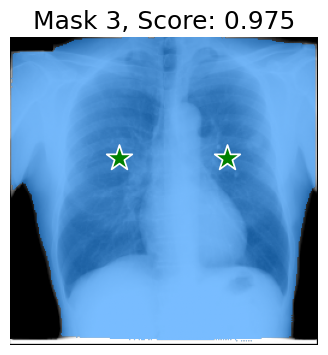

In [18]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [19]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in zip(x_val, y_val):
    # raise NotImplementedError("TODO: Predict segmentation with SAM and compute F1 score.")
    # YOUR CODE HERE
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
    )
    f1_scores.append(f1(torch.tensor(masks[0].reshape(-1)), 
                        torch.tensor(mask_gt.reshape(-1))))

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.7811
Standard deviation: 0.0475


# Using Bounding Boxes from GT segmentations as Prompt

[[148   8 233 216]
 [ 39  11 124 217]]


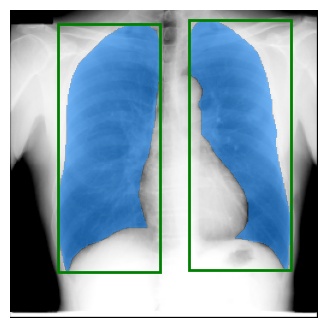

(<Figure size 640x480 with 0 Axes>, <Axes: >)

<Figure size 640x480 with 0 Axes>

In [42]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks
from collections import deque

def bfs(mask, start, visited):
    queue = deque([start])
    segment = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Left, Right, Up, Down
    directions += [(-1, -1), (1, 1), (1, -1), (-1, 1)] # Up-left, Down-right, Up-right, Down-left
    h, w = mask.shape

    while queue:
        x, y = queue.popleft()
        if not mask[x, y]:
            continue
        mask[x, y] = False
        segment.append([x,y])

        for dx, dy in directions:
            ny, nx = y + dy, x + dx
            if 0 <= nx < h and 0 <= ny < w and mask[nx, ny]:
                queue.append((nx, ny))

    return segment

def get_bonding_box(mask):
    bonding_boxes = []
    mask = mask.squeeze().copy()
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                # print(f'mask[{i}, {j}]')
                segment = np.array(bfs(mask, [i, j], mask))
                if len(segment) > 100:
                    # print('len(segment):', len(segment), segment.shape)
                    min_y, min_x = np.min(segment, axis=0)
                    max_y, max_x = np.max(segment, axis=0)
                    bonding_boxes.append([min_x, min_y, max_x, max_y])

    return np.array(bonding_boxes)

boxes = get_bonding_box(example_mask)
print(boxes)
plot_image_mask_box_points(image=example_img, masks=[example_mask], boxes=boxes)

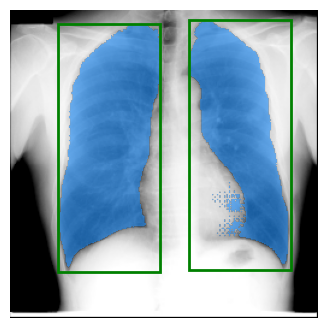

F1: 0.9543414115905762


<Figure size 640x480 with 0 Axes>

In [21]:
def box_prompt(image, boxes, mask_gt):
    input_boxes = torch.tensor(boxes, device=predictor.device)
    predictor.set_image(image)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    # masks.shape: torch.Size([4, 1, 1200, 1800])
    masks = masks[:, 0, :, :].squeeze().detach().cpu().numpy()
    united_mask = np.sum(masks, axis=0)
    plot_image_mask_box_points(image=image, 
                               masks=[united_mask], 
                               boxes=boxes)
    f1_core = f1(torch.tensor(united_mask.reshape(-1)), torch.tensor(mask_gt.reshape(-1))).item()
    return masks, united_mask, f1_core

prediction_masks, prediction_united_mask, f1_core = box_prompt(example_img, boxes=boxes, mask_gt=example_mask)
print('F1:', f1_core)

# Object Detection Model to predict Bounding Boxes

In [22]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes

## Generate datasets


In [23]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((112, 256, 256, 3),
 (112, 256, 256),
 (12, 256, 256, 3),
 (12, 256, 256),
 (123, 256, 256, 3),
 (123, 256, 256))

In [43]:
def generate_box_set(mask_dataset):
    box_set = []
    for mask in mask_dataset:
        boxes = get_bonding_box(mask)
        if boxes.shape != (2,4):
            plot_image_mask_box_points(image=example_img, 
                                        masks=[mask], 
                                        boxes=boxes)
            print('Error:', boxes.shape, boxes)
            break
        box_set.append(boxes)
    box_set = np.array(box_set)
    return box_set

box_set_train = generate_box_set(y_train)
print(box_set_train.shape)
box_set_test = generate_box_set(y_test)
print(box_set_test.shape)
box_set_val = generate_box_set(y_val)
print(box_set_val.shape)

(112, 2, 4)
(123, 2, 4)
(12, 2, 4)
